Julia Świątkowska: zadania 1 i 2


Kornel Natoński: zadania 3 i 4

# Mały projekt 1: wizualizacja poziomu zanieczyszczeń (PM2.5)

Główny Inspektorat Ochrony Środowiska (GIOS) udostępnia dane o jakości powietrza w Polsce na stronie [https://powietrze.gios.gov.pl](https://powietrze.gios.gov.pl), tj. poziom stężenia pyłów PM2.5, PM10, SO2 i innych zanieczyszczeń. Dane te są szczególnie przydatne w analizach środowiskowych i zdrowotnych. W tym zadaniu interesują nas godzinne pomiary stężeń drobnego pyłu **PM2.5** (pyłu o średnicy poniżej 2.5 µm) w latach **2014, 2019 i 2024**. Pyły PM2.5 są one bardzo szkodliwe dla zdrowia, gdyż mogąc przenikać głęboko do układu oddechowego i krwiobiegu. Zadanie polega na przeprowadzeniu analizy danych wraz z opisami czynności oraz wykresami.

## Wymagania ogólne

- Rozwiązanie należy przygotować w formie **Jupyter Notebooka (`.ipynb`)**.  Rozwiązanie proszę przesłać przez Moodle’a.
- Wszystkie operacje czyszczenia i łączenia danych wykonaj **programistycznie**, bez ręcznej edycji plików.
- Do każdego punktu należy obowiązkowo dodać opis z analizą otrzymanych wyników.  
- Zadanie należy wykonać w wylosowanych parach. Obie osoby z pary przesyłają **identyczne pliki** i dodają na początku notebooka opis swojego wkładu.
- Ocena jest wspólna dla pary, a nie indywidualna.

## Dane wejściowe i metadane

- Każdy rok to archiwum ZIP dostępne pod adresem [https://powietrze.gios.gov.pl/pjp/archives/](https://powietrze.gios.gov.pl/pjp/archives/).
- Wewnątrz znajdują się pliki Excel, np. `2024_PM25_1g.xlsx`.
- Poniższa funkcja `download_gios_archive` pozwala odczytać odpowiedni zbior danych; resztę danych pomijamy.
- Użyj pliku metadanych (dostępnego na tej samej stronie), aby zaktualizować **kody stacji** (część stacji mogła w międzyczasie zmienić nazwę). W metadanych znajdziesz odpowiednie kolumny.

## Zadania

### 1. Wczytanie i czyszczenie danych

Wczytaj dane dla lat **2014, 2019 i 2024**, oczyścić je z niepotrzebnych wierszy oraz ujednolić ich format. Zaktualizuj stare kody stacji zgodnie z metadanymi. Pozostaw tylko stacje występujące we wszystkich trzech latach. Informacje o stacjach pomiarowych warto uzupełnić o miejscowości dostępne w metadanych, np. za pomocą MultiIndex: (miejscowość, kod stacji). Pomiary dokonane o północy (00:00:00) powinny być potraktowane jako dotyczące poprzedniego dnia. Połącz dane z trzech lat w jeden `DataFrame` i zapisz do pliku.

### 2. Średnie miesięczne + trend dla miast

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

### 3. Heatmapa miesięcznych średnich

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

### 4. Dni z przekroczeniem normy (WHO)

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

## Dodatkowe wymagania i sugestie

- Notebook powinien zawierać *sanity checks*, np.:
  - liczba stacji w każdym pliku,
  - liczba dni w każdym roku,  
  - kilka przykładowych mapowań kodów stacji,  
- Wszystkie wykresy powinny mieć tytuły, legendy i krótki opis interpretacji.
- Zachęcamy do weryfikacji kodu napisanego przez drugą osobę, gdyż ocena jest wspólna.
- Można wykorzystać dowolne poznane biblioteki do analizy i wizualizacji danych w Pythonie.

## Kryteria oceny

- Zadanie 1: 3 pkt
- Zadanie 2: 2 pkt
- Zadanie 3: 1.5 pkt
- Zadanie 4: 2 pkt
- Jakość wyjaśnień, interpretacje, opis wkładu: 1.5 pkt



In [1]:
import pandas as pd
import requests
import zipfile
import io, os, re
from pathlib import Path
import matplotlib.pyplot as plt


In [2]:
# id archiwum dla poszczególnych lat
gios_archive_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
gios_url_ids = {2014: '302', 2019: '322', 2024: '582'}
gios_pm25_file = {2014: '2014_PM2.5_1g.xlsx', 2019: '2019_PM25_1g.xlsx', 2024: '2024_PM25_1g.xlsx'}

# funkcja do ściągania podanego archiwum
def download_gios_archive(year, gios_id, filename):
    # Pobranie archiwum ZIP do pamięci
    url = f"{gios_archive_url}{gios_id}"
    response = requests.get(url)
    response.raise_for_status()  # jeśli błąd HTTP, zatrzymaj
    
    # Otwórz zip w pamięci
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # znajdź właściwy plik z PM2.5
        if not filename:
            print(f"Błąd: nie znaleziono {filename}.")
        else:
            # wczytaj plik do pandas
            with z.open(filename) as f:
                try:
                    df = pd.read_excel(f, header=None)
                except Exception as e:
                    print(f"Błąd przy wczytywaniu {year}: {e}")
    return df


## Zadanie 1 - Wczytanie i czyszczenie danych

In [3]:
# wczytanie danych z poszczególnych lat
df2024 = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])
df2019 = download_gios_archive(2019, gios_url_ids[2019], gios_pm25_file[2019])
df2014 = download_gios_archive(2014, gios_url_ids[2014], gios_pm25_file[2014])

C:\Users\kolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [4]:
# df2024.head()

In [5]:
# sprawdź pierwsze 10 wierszy, aby zobaczyć jak wyglądają dane
for i in range(10):
    first_cell = str(df2024.iloc[i, 0])
    print(f"Wiersz {i}: {first_cell}")

Wiersz 0: Nr
Wiersz 1: Kod stacji
Wiersz 2: Wskaźnik
Wiersz 3: Czas uśredniania
Wiersz 4: Jednostka
Wiersz 5: Kod stanowiska
Wiersz 6: 2024-01-01 01:00:00
Wiersz 7: 2024-01-01 02:00:00
Wiersz 8: 2024-01-01 03:00:00
Wiersz 9: 2024-01-01 04:00:00


In [6]:
# funkcja do ściągania metadanych
def download_metadata(filename):
    '''Pobiera metadane z podanego URL i zwraca je jako DataFrame.'''
    try:
        response = requests.get(filename)
        response.raise_for_status() # jeśli błąd HTTP, zatrzymaj
        
        # Wczytaj metadane jako DataFrame
        df = pd.read_excel(io.BytesIO(response.content))
        print("Metadane pobrane pomyślnie")
        
        return df
    except Exception as e:
        print(f"Błąd przy pobieraniu metadanych: {e}")
        return None

df_metadata = download_metadata("https://powietrze.gios.gov.pl/pjp/archives/downloadFile/584")


Metadane pobrane pomyślnie


In [7]:
# wyświetlenie podstawowych informacji o metadanych
print(f"Kolumny: {list(df_metadata.columns)}")
print(df_metadata.head())

Kolumny: ['Nr', 'Kod stacji', 'Kod międzynarodowy', 'Nazwa stacji', 'Stary Kod stacji \n(o ile inny od aktualnego)', 'Data uruchomienia', 'Data zamknięcia', 'Typ stacji', 'Typ obszaru', 'Rodzaj stacji', 'Województwo', 'Miejscowość', 'Adres', 'WGS84 φ N', 'WGS84 λ E']
   Nr       Kod stacji Kod międzynarodowy                    Nazwa stacji  \
0   1         DsBialka                NaN                          Białka   
1   2       DsBielGrot                NaN  Bielawa - ul. Grota Roweckiego   
2   3  DsBogatFrancMOB            PL0602A                 Bogatynia Mobil   
3   4        DsBogChop            PL0315A             Bogatynia - Chopina   
4   5  DsBogZatonieMob            PL0576A               Bogatynia - Mobil   

  Stary Kod stacji \n(o ile inny od aktualnego) Data uruchomienia  \
0                                           NaN        1990-01-03   
1                                           NaN        1994-01-02   
2                                    DsBogatMob        2015-01

In [8]:
def clean_data(df, year, df_metadata):
    '''
    Czyści dane pomiarowe PM2.5 i przekształca do formatu długiego
    
    Parametry:
    df - dane z pomiarami
    year - rok danych
    df_metadata - metadane ze stacjami
    '''
    # kopia danych wejściowych
    df = df.copy()
    
    if year == 2024 or year == 2019:
        df_cleaned = df.drop([0, 2, 3, 4, 5])  # Usuwa wiersze z indeksami 2,3,4,5
        
    elif year == 2014:
        df_cleaned = df.drop([1, 2])  # Usuwa wiersze z indeksami 1,2
        
    else:
        raise ValueError(f"Nieobsługiwany format danych dla roku {year}")
    
    # zresetuj index po usunięciu wierszy
    df_cleaned = df_cleaned.reset_index(drop=True)
    
    print(f"Rok {year}: Po usunięciu niepotrzebnych wierszy - kształt: {df_cleaned.shape}")
    print(f"Rok {year}: Pierwszy wiersz danych: {df_cleaned.iloc[0, :5].tolist()}")
        
    # znajdź wiersz, w którym zaczynają się dane pomiarowe (z datami)
    date_pattern = r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}'
    data_start_row = None
    
    for idx in range(len(df_cleaned)):
        first_cell = str(df_cleaned.iloc[idx, 0])
        if re.match(date_pattern, first_cell):
            data_start_row = idx
            break
    
    if data_start_row is None:
        raise ValueError(f"Nie znaleziono wierszy z datami w pliku dla roku {year}")
    
    # przygotuj nagłówki kolumn - kody stacji są w wierszu 1
    station_codes = df_cleaned.iloc[0, 1:].tolist()  # Pomijamy pierwszą kolumnę "Kod stacji"
    
    # nowe nazwy kolumn: pierwsza to 'data', reszta to kody stacji
    new_columns = ['data'] + station_codes
    
    # wybierz tylko dane pomiarowe (od wiersza z datami)
    data_df = df_cleaned.iloc[data_start_row:].copy()
    data_df = data_df.reset_index(drop=True)
    
    # przypisz nowe nazwy kolumn
    data_df.columns = new_columns[:len(data_df.columns)]
    
    # rozwiń dane do formatu długiego
    df_long = data_df.melt(id_vars=['data'], var_name='kod_stacji', value_name='pm25')
    
    # aktualizuj stare kody stacji na podstawie metadanych
    if 'Stary Kod stacji \n(o ile inny od aktualnego)' in df_metadata.columns and 'Kod stacji' in df_metadata.columns:
        # stwórz słownik mapujący stare kody na nowe
        station_mapping = {}
        
        for idx, row in df_metadata.iterrows():
            old_codes = row['Stary Kod stacji \n(o ile inny od aktualnego)']
            new_code = str(row['Kod stacji']).strip()
            
            if pd.notna(old_codes) and old_codes != '':
                # rozbijwiele kodów oddzielonych przecinkami
                old_code_list = str(old_codes).split(',')
                
                for old_code in old_code_list:
                    old_code_clean = old_code.strip()
                    if old_code_clean:  # tylko niepuste kody
                        station_mapping[old_code_clean] = new_code
        
        print(f"Rok {year}: Utworzono mapowanie dla {len(station_mapping)} starych kodów stacji")
        
        df_long['kod_stacji'] = df_long['kod_stacji'].map(
            lambda x: station_mapping.get(str(x).strip(), str(x).strip())
        )
        
    else:
        print("Ostrzeżenie: Brak kolumn do mapowania starych kodów stacji w metadanych")
        
    # konwersja typów danych
    df_long['data'] = pd.to_datetime(df_long['data'], errors='coerce')

    df_long['pm25'] = df_long['pm25'].astype(str).str.replace(',', '.')
    df_long['pm25'] = pd.to_numeric(df_long['pm25'], errors='coerce')
    
    # dodaj miejscowość z metadanych
    if 'Kod stacji' in df_metadata.columns and 'Miejscowość' in df_metadata.columns:
        # utwórz słownik mapujący aktualne kody stacji na miejscowości
        station_to_city = df_metadata.set_index('Kod stacji')['Miejscowość'].to_dict()
        
        # mapuj używając już zaktualizowanych kodów stacji
        df_long['Miejscowość'] = df_long['kod_stacji'].map(station_to_city)
        
        # sprawdź brakujące mapowania
        missing_stations = df_long[df_long['Miejscowość'].isna()]['kod_stacji'].unique()
        if len(missing_stations) > 0:
            print(f"Ostrzeżenie: Brak mapowania miejscowości dla {len(missing_stations)} stacji: {list(missing_stations)}")
            
    else:
        raise KeyError("Brak kolumn 'Kod stacji' lub 'Miejscowość' w metadanych")
    
    print(df_long[['kod_stacji', 'Miejscowość']].drop_duplicates().head())
    
    # korekta pomiarów z godziny 00:00
    midnight_mask = df_long['data'].dt.hour == 0
    df_long.loc[midnight_mask, 'data'] = df_long.loc[midnight_mask, 'data'] - pd.Timedelta(days=1)
    print(f"Liczba unikalnych dni w roku {year}: {df_long['data'].dt.date.nunique()}")
    
    # posprzątaj kolumny
    final_columns = ['Miejscowość', 'kod_stacji', 'data', 'pm25']

    df_long = df_long[final_columns]
    
    return df_long

In [9]:
df2024_clean = clean_data(df2024, 2024, df_metadata)
df2019_clean = clean_data(df2019, 2019, df_metadata)
df2014_clean = clean_data(df2014, 2014, df_metadata)

Rok 2024: Po usunięciu niepotrzebnych wierszy - kształt: (8785, 97)
Rok 2024: Pierwszy wiersz danych: ['Kod stacji', 'DsChojnowMalMOB', 'DsJelGorOgin', 'DsKlodzSzkol', 'DsKudowaSzkoMOB']
Rok 2024: Utworzono mapowanie dla 302 starych kodów stacji
Ostrzeżenie: Brak mapowania miejscowości dla 1 stacji: ['LuLubsStrzelMOB']
            kod_stacji   Miejscowość
0      DsChojnowMalMOB       Chojnów
8784      DsJelGorOgin  Jelenia Góra
17568     DsKlodzSzkol       Kłodzko
26352  DsKudowaSzkoMOB  Kudowa-Zdrój
35136     DsWrocAlWisn       Wrocław
Liczba unikalnych dni w roku 2024: 366
Rok 2019: Po usunięciu niepotrzebnych wierszy - kształt: (8761, 64)
Rok 2019: Pierwszy wiersz danych: ['Kod stacji', 'DsDusznikMOB', 'DsJaworMOB', 'DsJelGorOgin', 'DsWrocAlWisn']
Rok 2019: Utworzono mapowanie dla 302 starych kodów stacji
         kod_stacji     Miejscowość
0      DsDusznikMOB  Duszniki-Zdrój
8760     DsJaworMOB           Jawor
17520  DsJelGorOgin    Jelenia Góra
26280  DsWrocAlWisn         Wrocław


In [10]:
print("Struktura danych z clen_data:")
print(f"Kolumny: {list(df2019_clean.columns)}")
print(df2024_clean.head())

Struktura danych z clen_data:
Kolumny: ['Miejscowość', 'kod_stacji', 'data', 'pm25']
  Miejscowość       kod_stacji                data  pm25
0     Chojnów  DsChojnowMalMOB 2024-01-01 01:00:00   NaN
1     Chojnów  DsChojnowMalMOB 2024-01-01 02:00:00   NaN
2     Chojnów  DsChojnowMalMOB 2024-01-01 03:00:00   NaN
3     Chojnów  DsChojnowMalMOB 2024-01-01 04:00:00   NaN
4     Chojnów  DsChojnowMalMOB 2024-01-01 05:00:00   NaN


In [11]:
# połącz wszystkie lata w jeden DataFrame
df_all = pd.concat([df2014_clean, df2019_clean, df2024_clean], ignore_index=True)

# zachowaj tylko wspólne stacje
common_stations = (
    set(df2014_clean['kod_stacji']) &
    set(df2019_clean['kod_stacji']) &
    set(df2024_clean['kod_stacji'])
)
df_all = df_all[df_all['kod_stacji']. isin(common_stations)]

# ustaw multiindex
df_all = df_all.set_index(['Miejscowość', 'kod_stacji']).sort_index()

# zapisz do pliku csv
df_all.to_csv('pm25_cleaned.csv')

In [12]:
df_all = pd.read_csv('pm25_cleaned.csv')
df_all.head()

,Miejscowość,kod_stacji,data,pm25
0,Bydgoszcz,KpBydPlPozna,2014-01-01 01:00:00,116.214424
1,Bydgoszcz,KpBydPlPozna,2014-01-01 02:00:00,NaN
2,Bydgoszcz,KpBydPlPozna,2014-01-01 03:00:00,NaN
3,Bydgoszcz,KpBydPlPozna,2014-01-01 04:00:00,NaN
4,Bydgoszcz,KpBydPlPozna,2014-01-01 05:00:00,NaN


## Zadanie 2 - Średnie miesięczne + trend dla miast

Kolumny w monthly_avg: ['Miejscowość', 'kod_stacji', 'rok', 'miesiąc', 'pm25']


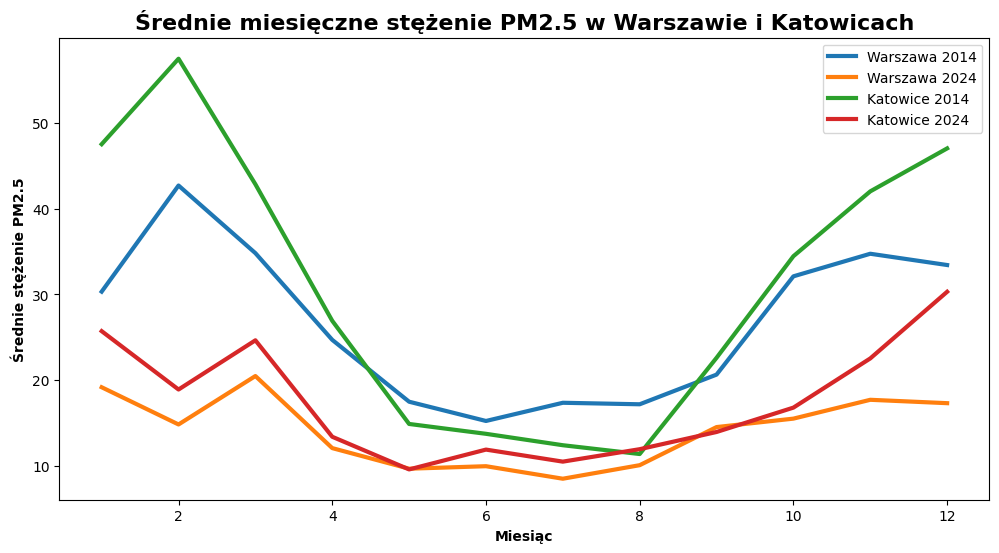

In [13]:
# po wczytaniu danych z CSV konwertuj kolumnę daty
df_all['data'] = pd.to_datetime(df_all['data'], errors='coerce')

# grupuj dane oraz oblicz średnie miesięczne wartości PM2.5
monthly_avg = df_all.groupby([
    'Miejscowość', 
    'kod_stacji', 
    df_all['data'].dt.year.rename('rok'), # wyodrębnienie roku z daty
    df_all['data'].dt.month.rename('miesiąc') # wyodrębnienie miesiąca z daty
])['pm25'].mean().reset_index()

print('Kolumny w monthly_avg:', monthly_avg.columns.to_list())

# wyciagnij dane tylko dla Warszawy i Katowic z lat 2014 oraz 2024
war_kat_data = monthly_avg[(monthly_avg['Miejscowość'].isin(['Warszawa', 'Katowice'])) &
                           (monthly_avg['rok'].isin([2014, 2024]))]

# sprawdz wynik powyzszych operacji
# print("Unikalne miasta:", war_kat_data['Miejscowość'].unique())
# print("Unikalne lata:", war_kat_data['rok'].unique())

# agregacja danych, oblicz średnie wartości PM2.5 dla każdego miasta, roku i miesiąca
# (uśrednienie pomiarów z różnych stacji w tym samym mieście)
cities_avg = war_kat_data.groupby(['Miejscowość', 'rok', 'miesiąc'])['pm25'].mean().reset_index()

# przygotowanie wykresu
plt.figure(figsize=(12,6))

for city in ['Warszawa', 'Katowice']:
    for year in [2014, 2024]:
        # filtruj dane dla danej kombinacji
        data = cities_avg[
            (cities_avg['Miejscowość'] == city) & 
            (cities_avg['rok'] == year)
        ].sort_values('miesiąc')

        # rysuj linie
        plt.plot(data['miesiąc'], data['pm25'], label=f'{city} {year}', linewidth=3)

plt.xlabel('Miesiąc', weight='bold')
plt.ylabel('Średnie stężenie PM2.5', weight='bold')
plt.title('Średnie miesięczne stężenie PM2.5 w Warszawie i Katowicach', weight='bold', fontsize=16)
plt.legend()
plt.show()


## Interpretacja wykresu
Na wykresie wyraźnie widoczna jest sezonowość zanieczyszczenia powietrza, z charakterystycznymi wzrostami stężeń PM2.5 w miesiącach zimowych (wrzesień-marzec). Bezpośrednio wiąże się to ze zwiększonym zapotrzebowaniem na ogrzewanie budynków i dominacją tzw. "niskiej emisji" (emisja z niskich kominów - domów jednorodzinnych, kamienic) z indywidualnych systemów grzewczych, w których często spalane są paliwa stałe (głównie węgiel), a niekiedy nawet odpady.

Różnice obserwowane między rokiem 2014 a 2024 są znaczące i mogą stanowić pozytywny sygnał poprawy jakości powietrza. Trend spadkowy prawdopodobnie odzwierciedla efekty wieloletnich działań naprawczych, w tym krajowych i lokalnych programów dotacyjnych, takich jak "Czyste Powietrze", które finansują wymianę przestarzałych pieców na ekologiczne źródła ciepła. Zaobserwowaną poprawę można również łączyć z rosnącą świadomością ekologiczną społeczeństwa. Warto również zauważyć, że różnice między miastami mogą wynikać z ich specyfiki - podczas gdy Warszawa zmaga się głównie z emisjami komunikacyjnymi, Katowice pozostają pod wpływem historycznego obciążenia przemysłem i strukturą zabudowy.

## Zadanie 3 - Heatmapa miesięcznych średnich

In [41]:
import numpy as np

miasta = []
macierze = []


for i,[miejscowosc, dfi] in enumerate(monthly_avg.groupby("Miejscowość")):
    miasta.append(miejscowosc)
    dane_z_lat = []

    for j, [rok, dfj] in enumerate(dfi.groupby("rok")):
        #print(rok)
        df_mean = dfj.groupby("miesiąc")["pm25"].mean()

        dane_z_lat.append(df_mean.to_numpy())

    macierze.append(np.vstack(dane_z_lat))


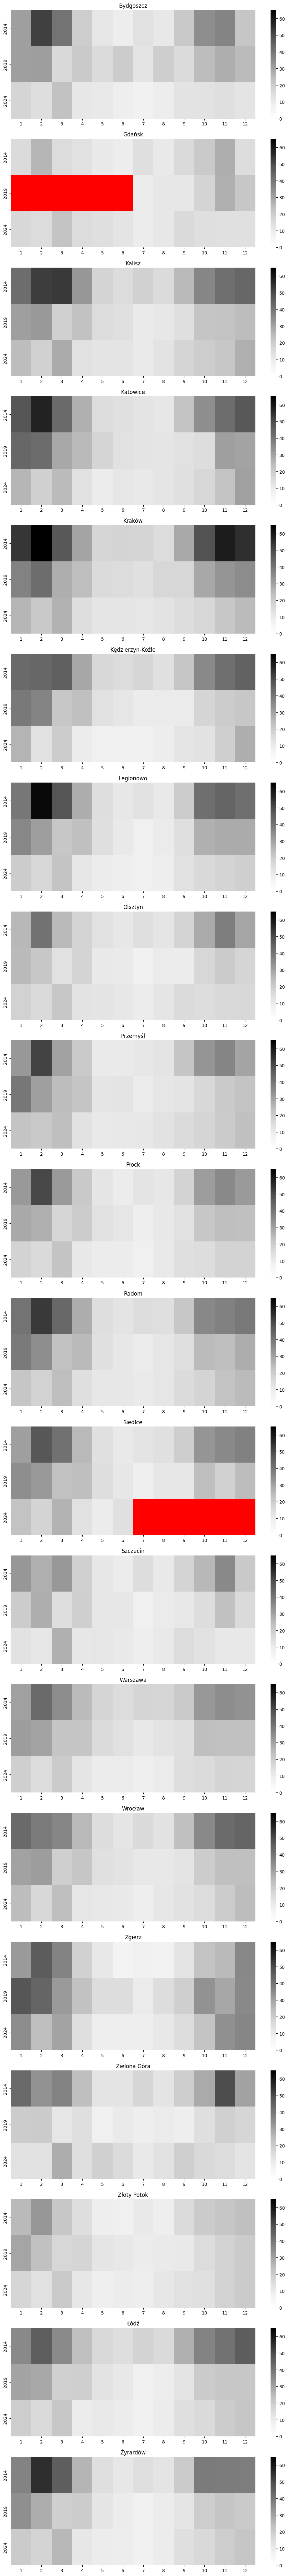

In [44]:
import seaborn as sns
from matplotlib import colormaps
years = [2014, 2019, 2024]

fig, axes = plt.subplots(len(macierze), 1, figsize=(10, 4*len(macierze)))
cmap = colormaps["Greys"].copy()
cmap.set_bad(color="red")

if len(macierze) == 1:
    axes = [axes]

for ax, miasto, arr in zip(axes, miasta, macierze):
    sns.heatmap(arr, 
                ax=ax, 
                xticklabels=range(1,13), 
                yticklabels=years,
                annot=False,
                cmap=cmap,
                vmin=0,             
                vmax=65,           
                mask=np.isnan(arr))
    ax.set_title(miasto)

plt.tight_layout()
plt.show()

Maksymalne wartości zanieczyszczenia znacząco różnią się w zależności od miasta. Najwyższe miesięczne wartości notowano zazwyczaj w 2014 roku.

W przeważajacej części miast w miesiącach zimowych, gdzie występuje największe zanieczyszczenie, sytuacja poprawiła się na przestrzeni lat. Jednak tempo zmian jest różne w zależności od miasta. Np. w grudniu w Zgierzu notowano jednakowe zanieczyszczenie na przestrzeni lat.  

## Zadanie 4 - Dni z przekroczeniem normy

In [49]:
daily_avg = df_all.groupby([
    'Miejscowość', 
    'kod_stacji', 
    df_all['data'].dt.year.rename('rok'), # wyodrębnienie roku z daty
    df_all['data'].dt.month.rename('miesiąc'), # wyodrębnienie miesiąca z daty
    df_all['data'].dt.day.rename('dzien') # wyodrębnienie dnia z daty
])['pm25'].mean().reset_index()

In [50]:
print(daily_avg)

      Miejscowość    kod_stacji   rok  miesiąc  dzien       pm25
0       Bydgoszcz  KpBydPlPozna  2014        1      1  89.176935
1       Bydgoszcz  KpBydPlPozna  2014        1      2  66.628389
2       Bydgoszcz  KpBydPlPozna  2014        1      3  52.670562
3       Bydgoszcz  KpBydPlPozna  2014        1      4  38.405468
4       Bydgoszcz  KpBydPlPozna  2014        1      5  29.585035
...           ...           ...   ...      ...    ...        ...
25203    Żyrardów  MzZyraRoosev  2024       12     27  33.700000
25204    Żyrardów  MzZyraRoosev  2024       12     28  23.654167
25205    Żyrardów  MzZyraRoosev  2024       12     29  40.633333
25206    Żyrardów  MzZyraRoosev  2024       12     30  16.933333
25207    Żyrardów  MzZyraRoosev  2024       12     31  22.662500

[25208 rows x 6 columns]


In [59]:
dni_powyzej_normy_w_stacjach = (
    daily_avg
    .query("pm25 > 15")
    .groupby(["kod_stacji", "Miejscowość", "rok"])
    .size()
    .reset_index(name="dni_powyzej_normy")
)


print(dni_powyzej_normy_w_stacjach)

      kod_stacji Miejscowość   rok  dni_powyzej_normy
0   DsWrocAlWisn     Wrocław  2014                255
1   DsWrocAlWisn     Wrocław  2019                180
2   DsWrocAlWisn     Wrocław  2024                134
3   KpBydPlPozna   Bydgoszcz  2014                218
4   KpBydPlPozna   Bydgoszcz  2019                218
..           ...         ...   ...                ...
64  ZpSzczAndrze    Szczecin  2019                116
65  ZpSzczAndrze    Szczecin  2024                 72
66  ZpSzczPilsud    Szczecin  2014                213
67  ZpSzczPilsud    Szczecin  2019                163
68  ZpSzczPilsud    Szczecin  2024                130

[69 rows x 4 columns]


In [61]:
dni_powyzej_normy_w_stacjach2024 = dni_powyzej_normy_w_stacjach[dni_powyzej_normy_w_stacjach["rok"]==2024]

top3 = dni_powyzej_normy_w_stacjach2024.nlargest(3, "dni_powyzej_normy")
print(top3)

bottom3 = dni_powyzej_normy_w_stacjach2024.nsmallest(3, "dni_powyzej_normy")
print(bottom3)

      kod_stacji Miejscowość   rok  dni_powyzej_normy
11  LdZgieMielcz      Zgierz  2024                189
17  MpKrakAlKras      Kraków  2024                178
53  SlKatoKossut    Katowice  2024                165
      kod_stacji Miejscowość   rok  dni_powyzej_normy
65  ZpSzczAndrze    Szczecin  2024                 72
32  MzSiedKonars     Siedlce  2024                 79
38  MzWarWokalna    Warszawa  2024                102


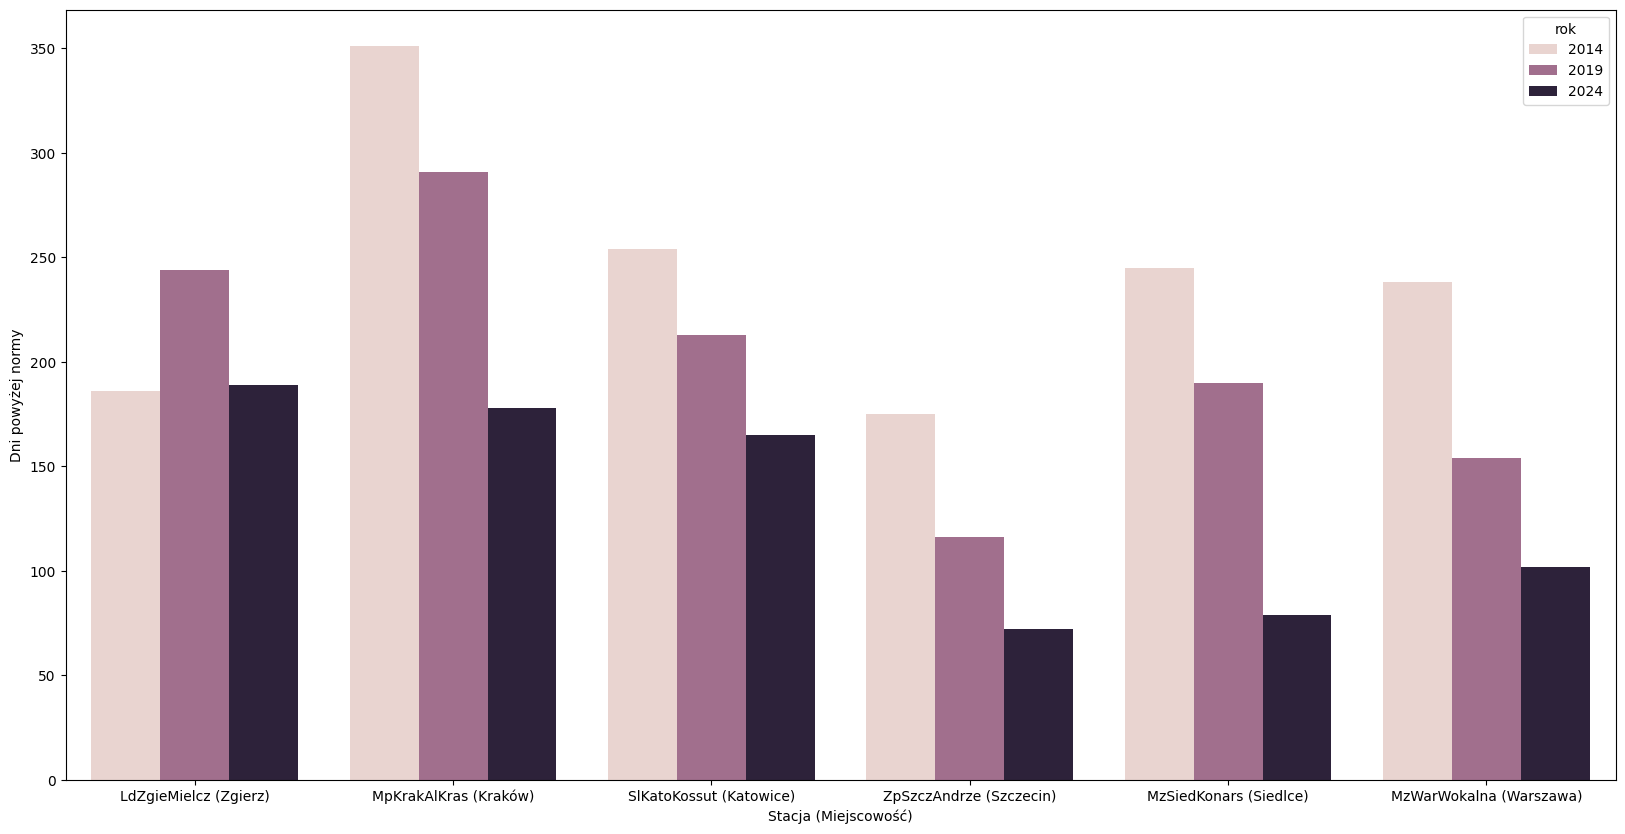

In [72]:
selected_stations = pd.concat([top3, bottom3])
station_order = selected_stations["kod_stacji"].tolist()
df_plot = dni_powyzej_normy_w_stacjach[dni_powyzej_normy_w_stacjach["kod_stacji"].isin(station_order)].copy()
df_plot["label"] = df_plot["kod_stacji"] + " (" + df_plot["Miejscowość"] + ")"
label_order = df_plot.drop_duplicates("kod_stacji").set_index("kod_stacji").loc[station_order]["label"]

plt.figure(figsize=(20,10))
sns.barplot(data=df_plot, x="label", y="dni_powyzej_normy", hue="rok", order=label_order)
plt.xlabel("Stacja (Miejscowość)")
plt.ylabel("Dni powyżej normy")
plt.show()

Sytuacja w roku 2024 nie pokrywa się w sytuacją z lat poprzednich. Np. stacja LdZgieMielcz w Zgierzu, która w 2024 miała najwięcej dni powyżej normy, jeszcze w 2014 miała ich mniej niż stacja MzWarWokalna w Warszawie, która w 2024 roku miała ich najmniej ze wszystkich. 

Wśród sześciu badanych stacji jedynie LdZgieMielcz nie utrzymuje trendu spadkowego od 2014 roku. Rokiem z największą ilością dni powyżej normy był tam 2019.

W ogólności można powiedzieć, że dane wskazują na poprawę sytuacji względem 2014 roku. W większości przypadków nawet w stacjach z największą liczbą dni powyżej normy w 2024 roku, ich liczba jest mniejsza niż notowana w 2014 roku w obecnie "najczystrzych" stacjach. Wyjątek stanowi porównanie LDZgieMielcz w 2024 i ZpSzczAndrze w 2014, ale nawet tu wyniki są bardzo podobne.